In [1]:
from HeaderP import *

In [2]:
import Astraea

In [3]:
def readsimdata(simNo,z,Rcut,select,Rcut_thread,zcut_thread):
    if simNo=='data':
        data=pd.read_pickle('../SecondYear/CannonDR16_cut.pkl')
        data['z_today']=data['z']
        data['x_today']=data['X']
        data['y_today']=data['Y']
        data['feh_scale']=data['M_H']
        data['ofe_scale']=data['O_FE']
        data['age']=data['Age']
    elif select:
        data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'_apogee_selec.pkl')
        data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
        data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
        scale_fe=0.250019907951355/0.35828184923028494
        scale_o=0.10861970484256744/0.09543676896214373
        data['feh_scale']=data['feh']*scale_fe-0.0906638577580452+0.08980628554112494
        data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-0.17121922547292423
        data['dR']=data['R']-data['R_bir']
        data['dz']=abs(data['z_today'])-abs(data['z_birth'])
    
    elif not select:
        if z=='0':
            data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'.pkl')
        else:
            data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'_z'+z+'.pkl')
            try:
                data['x_today']=data['x']
                data['y_today']=data['y']
                data['z_today']=data['z']
            except:
                print(np.shape(data['x_today']))

        data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
        data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
        scale_fe=0.250019907951355/0.35828184923028494
        scale_o=0.10861970484256744/0.09543676896214373
        data['feh_scale']=data['feh']*scale_fe-0.0906638577580452+0.08980628554112494
        data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-0.17121922547292423
        
        if Rcut:
            data=data.loc[data['R_bir']<Rcut_thread].reset_index(drop=True)
            data=data.loc[abs(data['z_birth'])<zcut_thread].reset_index(drop=True)
        data['dR']=data['R']-data['R_bir']
        data['dz']=abs(data['z_today'])-abs(data['z_birth'])
    return data
        

# load simulation

In [331]:
simNo='2_79e12'
z='0'
Rcut=True
select=False
Rcut_thread=30
zcut_thread=5


data=readsimdata(simNo,z,Rcut,select,Rcut_thread,zcut_thread)

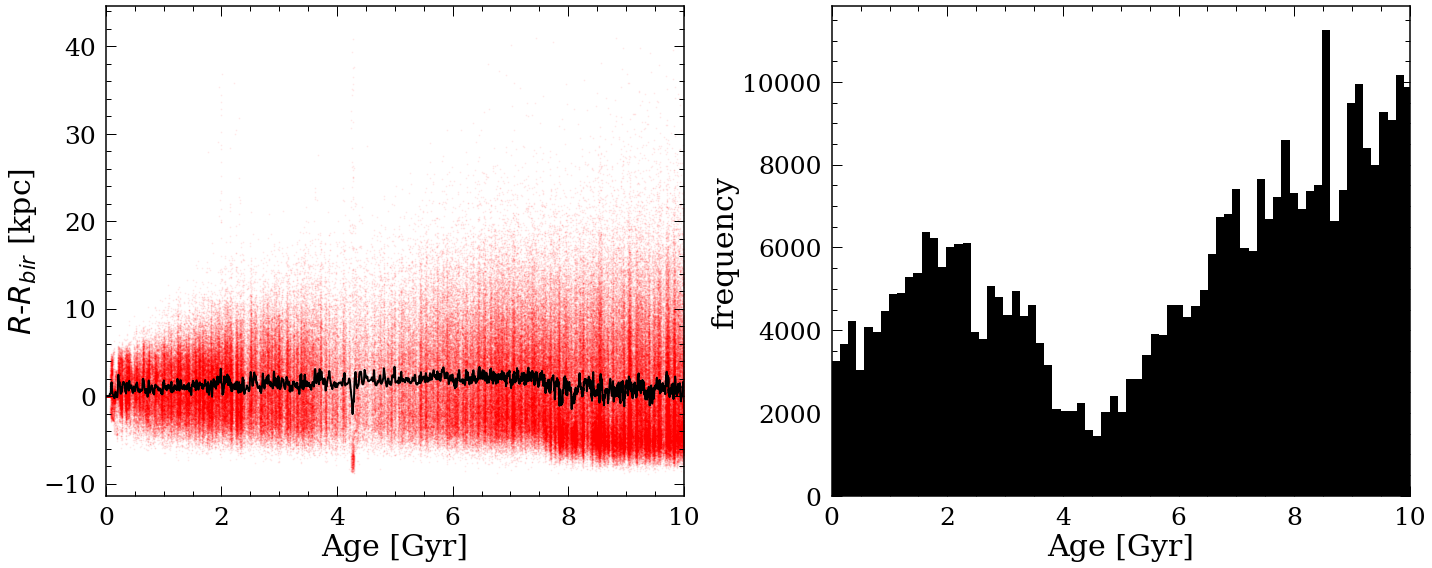

In [332]:
from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(20,8))
m = ((data['R_bir']>7)&(data['R_bir']<9))
data_sr=data[m]
plt.subplot(1,2,1)
plt.scatter(data_sr['age'],data_sr['dR'],s=1,c='r',alpha=0.05)
dr_smooth = gaussian_filter1d(data_sr['dR'], 100)
plt.plot(data_sr['age'],dr_smooth,'k-')
plt.xlabel('Age [Gyr]')
plt.ylabel('$R$-$R_{bir}$ [kpc]')
plt.xlim([0,10])

plt.subplot(1,2,2)
plt.hist(data_sr['age'],bins=np.linspace(0,14,100),color='k')
plt.xlabel('Age [Gyr]')
plt.ylabel('frequency')
plt.xlim([0,10])
plt.tight_layout()

<ipython-input-333-21ac36bf67ff>:19: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xf, 0.4/xf, 'r--',label='1/$f$ (pink noise)')
<ipython-input-333-21ac36bf67ff>:20: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xf, 4/xf**2, 'b--',label='1/$f^2$ (Brown noise, random walk)')


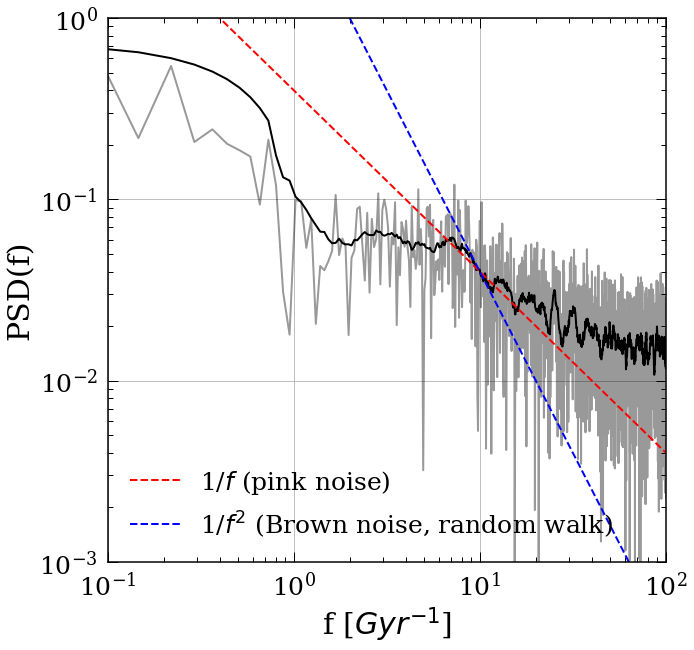

In [333]:
age_order, dr_order, dr_order_smooth = zip(*sorted(zip(data_sr['age'],data_sr['dR'],dr_smooth)))

from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq
N = len(age_order)
T = max(age_order)/N
yf = fft(dr_order)
#yf = fft(dr_order_smooth)
xf = fftfreq(N, T)[:N//2]

import matplotlib.pyplot as plt
PSD = 2.0/N * np.abs(yf[0:N//2])
plt.loglog(xf,PSD,'k-',alpha=0.4)

#PSD_smooth = gaussian_filter1d(PSD, 5)
PSD_smooth = savgol_filter(PSD, 21, 1)
plt.loglog(xf,PSD_smooth,'k-')

plt.plot(xf, 0.4/xf, 'r--',label='1/$f$ (pink noise)')
plt.plot(xf, 4/xf**2, 'b--',label='1/$f^2$ (Brown noise, random walk)')
plt.grid()
plt.xlim([0.1,1/0.01])
plt.ylim([1e-3,1])
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')
plt.legend(loc=3)

In [334]:
from astropy.timeseries import LombScargle
periods = np.linspace(0.1, 14, 1000)
#power = LombScargle(data_sr['age'], data_sr['dR']).power(frequency)
power = LombScargle(age_order, dr_order).power(2*np.pi/periods)

Text(0, 0.5, 'LS Power')

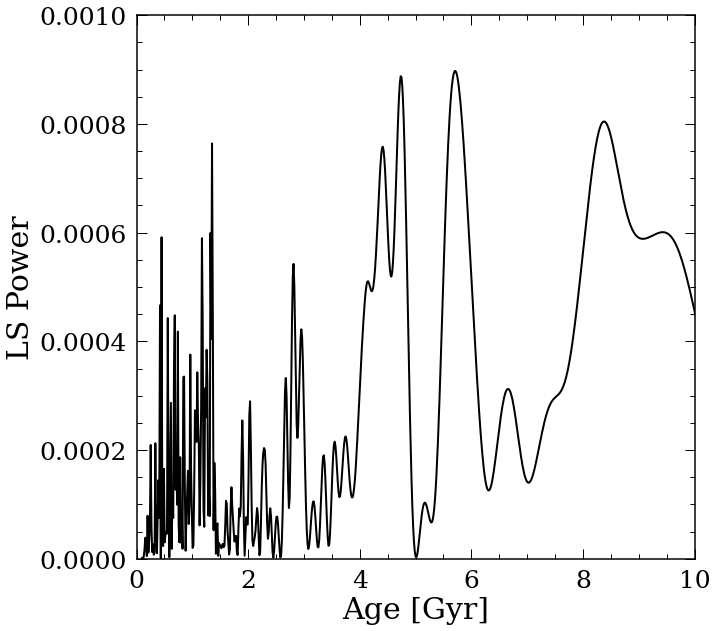

In [335]:
plt.plot(periods, np.array(power,dtype=float),'k-')
plt.ylim([0,0.001])
plt.xlim([0,10])
plt.xlabel('Age [Gyr]')
plt.ylabel('LS Power')

# make uniform distribution of stars

In [336]:
agebins=np.linspace(0,10,100)
agebin_no=np.zeros(len(agebins)-1)
age_order, dr_order = np.array(age_order), np.array(dr_order)
for i in trange(len(agebins)-1):
    m_age=((age_order>agebins[i])&(age_order<agebins[i+1]))
    agebin_no[i]=sum(m_age)


100%|██████████| 99/99 [01:17<00:00,  1.27it/s]


In [337]:
numbselect=int(min(agebin_no))
selectage=np.zeros(numbselect*len(agebins))
selectdr=np.zeros(numbselect*len(agebins))
for i in trange(len(agebins)-1):
    m_age=((age_order>agebins[i])&(age_order<agebins[i+1]))
    selectage[i*numbselect:(i+1)*numbselect]=np.random.choice(age_order[m_age], numbselect)
    selectdr[i*numbselect:(i+1)*numbselect]=np.random.choice(dr_order[m_age], numbselect)

100%|██████████| 99/99 [00:00<00:00, 2633.34it/s]


In [338]:
selectage, selectdr = selectage[selectage!=0], selectdr[selectage!=0]

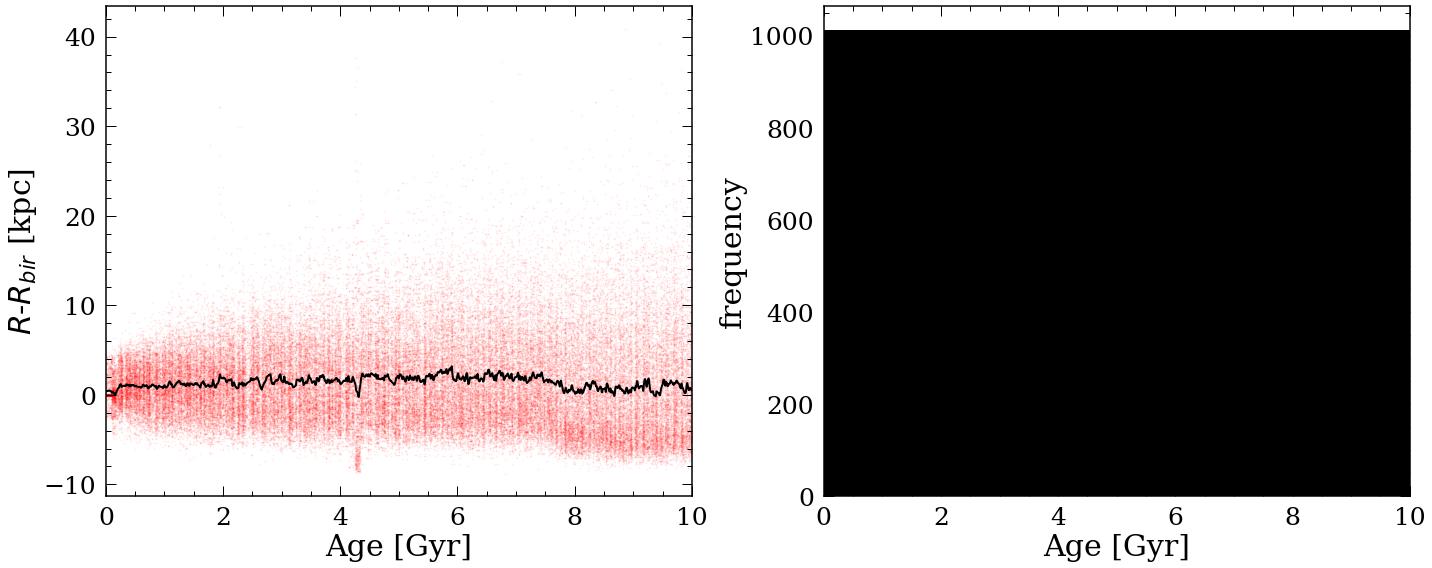

In [339]:
age_order_sel, dr_order_sel = zip(*sorted(zip(selectage, selectdr)))

from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(age_order_sel,dr_order_sel,s=1,c='r',alpha=0.05)
dr_smooth_sel = gaussian_filter1d(dr_order_sel, 100)
plt.plot(age_order_sel,dr_smooth_sel,'k-')
plt.xlabel('Age [Gyr]')
plt.ylabel('$R$-$R_{bir}$ [kpc]')
plt.xlim([0,10])

plt.subplot(1,2,2)
plt.hist(age_order_sel,bins=np.linspace(0,10,100),color='k')
plt.xlabel('Age [Gyr]')
plt.ylabel('frequency')
plt.xlim([0,10])
plt.tight_layout()

<ipython-input-340-767041067fa0>:18: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xf, 0.2/xf, 'r--',label='1/$f$ (pink noise)')
<ipython-input-340-767041067fa0>:19: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xf, 0.1/xf**0.55, 'b--',label='1/$f^{0.55}$')


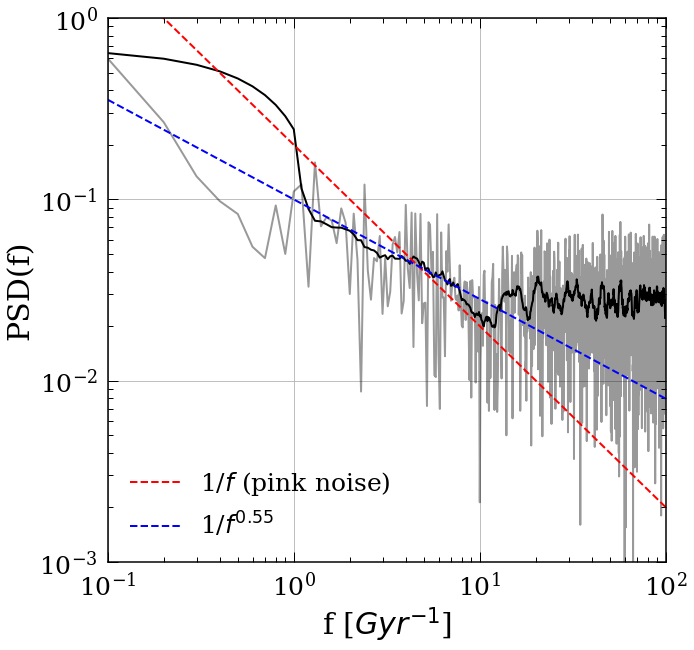

In [340]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.fft import fft, fftfreq
N = len(age_order_sel)
T = max(age_order_sel)/N
yf = fft(dr_order_sel)
#yf = fft(dr_smooth_sel)
xf = fftfreq(N, T)[:N//2]

import matplotlib.pyplot as plt
PSD = 2.0/N * np.abs(yf[0:N//2])
plt.loglog(xf,PSD,'k-',alpha=0.4)

#PSD_smooth = gaussian_filter1d(PSD, 5)
PSD_smooth = savgol_filter(PSD, 21, 1)
plt.loglog(xf,PSD_smooth,'k-')

plt.plot(xf, 0.2/xf, 'r--',label='1/$f$ (pink noise)')
plt.plot(xf, 0.1/xf**0.55, 'b--',label='1/$f^{0.55}$')
plt.grid()
plt.xlim([0.1,1/0.01])
plt.ylim([1e-3,1])
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')
plt.legend(loc=3)

In [341]:
from astropy.timeseries import LombScargle
periods = np.linspace(0.1, 10, 1000)
power = LombScargle(age_order_sel, dr_order_sel).power(2*np.pi/periods)

Text(0, 0.5, 'LS Power')

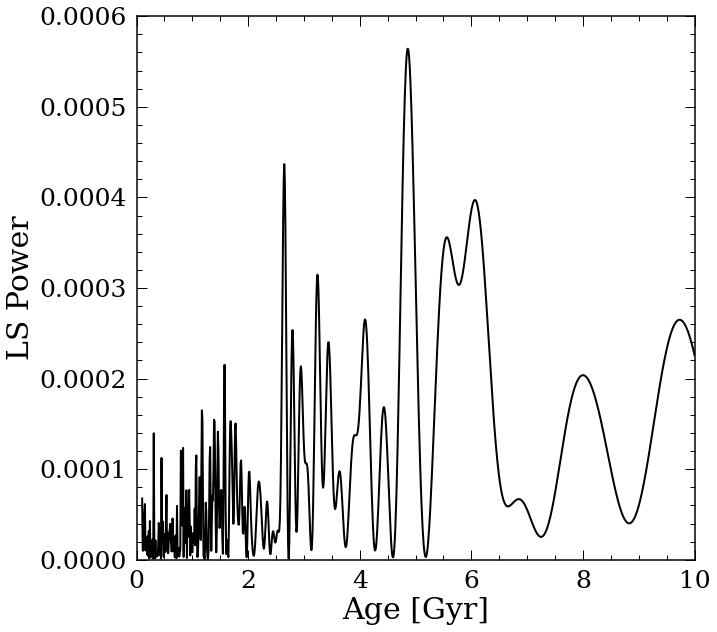

In [342]:
plt.plot(periods, np.array(power,dtype=float),'k-')
plt.ylim([0,0.0006])
plt.xlim([0,10])
plt.xlabel('Age [Gyr]')
plt.ylabel('LS Power')